In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch_geometric.loader import NeighborLoader
import utilities

In [2]:
# Define synthetic data parameters
num_samples = 8000
num_dimensions = 2
tau = 2
sigma = 1
phi = 10

# Define NN-GLS parameters
num_neighbors = 4
sigma_init = 0.1

# Define training parameters
num_epochs = 1000
batch_size = 400
learning_rate = 0.0001

# Define constants
NUM_FEATURES = 5

In [3]:
# Generate synthetic data
train_data = utilities.generate_samples(num_samples, num_dimensions, num_neighbors, tau, sigma, phi)
test_data = utilities.generate_samples(num_samples, num_dimensions, num_neighbors, tau, sigma, phi)

In [4]:
# Compute benchmark MSE (always predicting the mean)
benchmark_preds = torch.full(test_data.y.shape, train_data.y.mean())
benchmark_mse = torch.nn.functional.mse_loss(benchmark_preds, test_data.y)
print(f'Benchmark MSE: {benchmark_mse:.3f}')

Benchmark MSE: 6.156


In [5]:
# Create dataloader, model, and optimizer
train_loader = NeighborLoader(train_data, input_nodes=torch.tensor(range(num_samples)), num_neighbors=[num_neighbors], batch_size=batch_size, replace=False, shuffle=True)
model = utilities.NNGLS(num_features=NUM_FEATURES, num_neighbors=num_neighbors, num_dimensions=num_dimensions, sigma=sigma_init)
print(f"sigma: {model.sigma.item():.3f}, phi: {model.phi.item():.3f}, tau: {model.tau.item():.3f}")
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

sigma: 0.100, phi: 9.237, tau: 1.075


In [6]:
training_log = {'loss': [], 'metric': [], 'sigma': [], 'phi': [], 'tau': []}

# Training/evaluation loop
for epoch in range(num_epochs):
    # Train for one epoch
    model.train()
    for batch_idx, batch in enumerate(train_loader):
        optimizer.zero_grad()
        decorrelated_preds, decorrelated_targets, preds = model(batch)
        loss = torch.nn.functional.mse_loss(decorrelated_preds[:batch_size], decorrelated_targets[:batch_size])
        metric = torch.nn.functional.mse_loss(preds[:batch_size], batch.y[:batch_size])
        loss.backward()
        optimizer.step()
    # Compute predictions on held-out test test
    model.eval()
    decorrelated_preds, decorrelated_targets, preds = model(test_data)
    training_log["loss"].append(torch.nn.functional.mse_loss(decorrelated_preds, decorrelated_targets).item())
    training_log["metric"].append(torch.nn.functional.mse_loss(preds, test_data.y).item())
    training_log["sigma"].append(model.sigma.item())
    training_log["phi"].append(model.phi.item())
    training_log["tau"].append(model.tau.item())
    print(f"\rEpoch {epoch}, Loss: {training_log['loss'][-1]:.3f}, Metric: {training_log['metric'][-1]:.3f}, sigma: {training_log['sigma'][-1]:.3f}, phi: {training_log['phi'][-1]:.3f}, tau: {training_log['tau'][-1]:.3f}", end="")

Epoch 999, Loss: 0.525, Metric: 7.417, sigma: 1.250, phi: 7.330, tau: 2.755

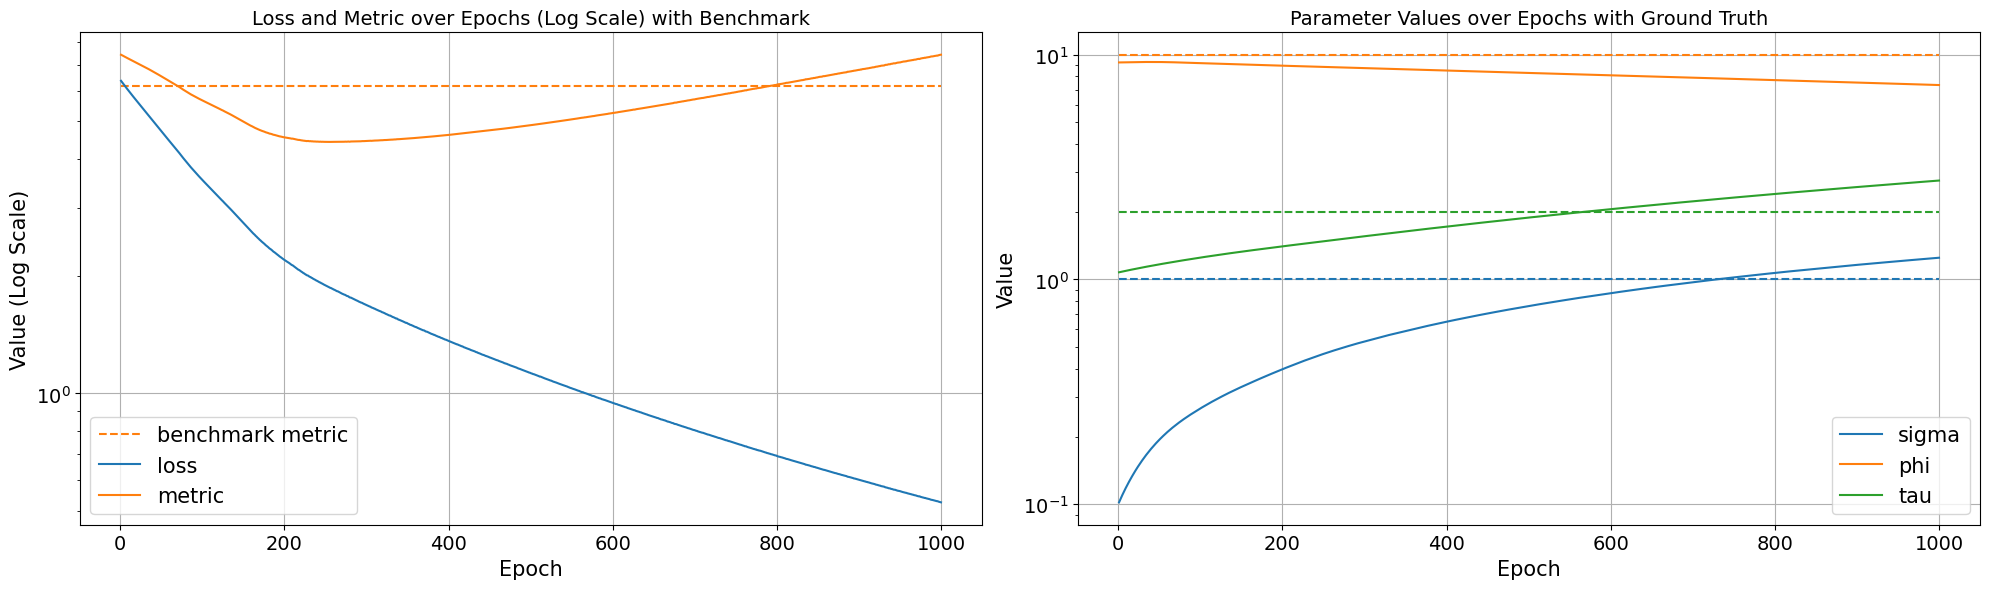

In [7]:
training_log["epoch"] = list(range(1, num_epochs+1))
training_log = pd.DataFrame(training_log)

# Melting the dataframe to make it suitable for seaborn plotting
training_log_melted = training_log[["epoch", "loss", "metric"]].melt(id_vars='epoch', var_name='Variable', value_name='Value')

# Finding the color used for the 'metric' in the plot
palette = sns.color_palette()
metric_color = palette[1]  # Assuming 'metric' is the second line in the plot

# Plotting with seaborn
# Creating two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
benchmark_line = axes[0].hlines(y=benchmark_mse, xmin=1, xmax=num_epochs, color=metric_color, linestyle='--', label='benchmark metric')
sns.lineplot(ax=axes[0], data=training_log_melted, x='epoch', y='Value', hue='Variable', style='Variable', markers=False, dashes=False)

axes[0].set_title('Loss and Metric over Epochs (Log Scale) with Benchmark', fontsize=14)
axes[0].set_xlabel('Epoch', fontsize=15)
axes[0].set_ylabel('Value (Log Scale)', fontsize=15)
axes[0].set_yscale('log')
axes[0].legend(prop={'size': 15})
axes[0].tick_params(labelsize=14)
axes[0].grid(True)


# Second plot (sigma, phi, tau)
kernel_params_melted = training_log[["epoch", "sigma", "phi", "tau"]].melt(id_vars='epoch', var_name='Variable', value_name='Value')
ground_truth = {'sigma': sigma, 'phi': phi, 'tau': tau}
sns.lineplot(ax=axes[1], data=kernel_params_melted, x='epoch', y='Value', hue='Variable', style='Variable', markers=False, dashes=False)
palette = sns.color_palette()
for i, (param, gt_value) in enumerate(ground_truth.items()):
    axes[1].hlines(y=gt_value, xmin=1, xmax=num_epochs, color=palette[i], linestyle='--')
axes[1].set_title('Parameter Values over Epochs with Ground Truth', fontsize=14)
axes[1].set_xlabel('Epoch', fontsize=15)
axes[1].set_ylabel('Value', fontsize=15)
axes[1].set_yscale('log')
axes[1].legend(prop={'size': 15})
axes[1].tick_params(labelsize=14)
axes[1].grid(True)

plt.tight_layout()